In [1]:
#importing the library
import os
print(os.getcwd())

C:\Users\Dell\Desktop\DeepLearning\SupervisedMachineLearning


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import(
Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Load the dataset
from keras.datasets import cifar10

In [4]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

In [5]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# Data Preprocessing and visualization

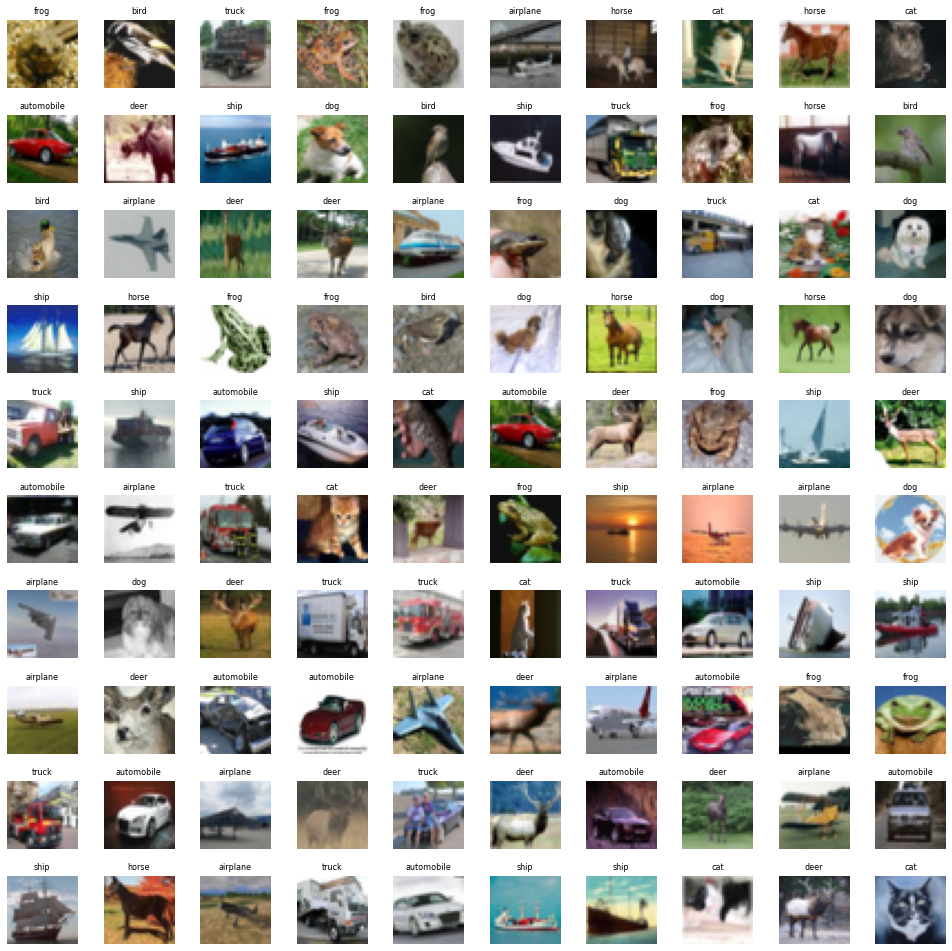

In [6]:
#define the label of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
         'dog', 'frog', 'horse', 'ship', 'truck']


W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize=(17, 17))

axes = axes.ravel() #flatten the 15 x 15 matrix with 255 array

n_train = len(X_train)

#select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): #create evenly spaces variables
    index = np.random.randint(0, n_train)
    
    axes[i].imshow(X_train[index, 1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize=8)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

Text(0.5, 1.0, 'Class distribution in training set')

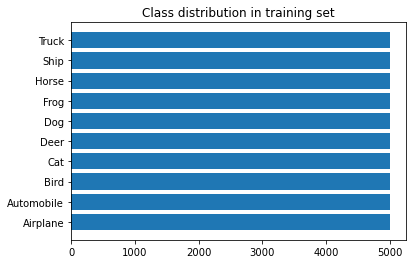

In [7]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog',
               'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts = True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

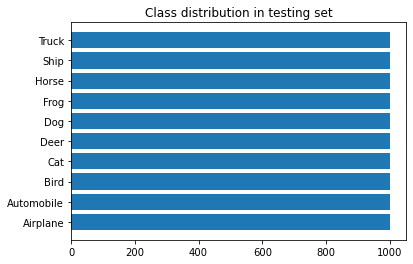

In [8]:
classes, counts = np.unique(y_test, return_counts = True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

# Data Preprocessing

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [10]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Build the CNN Model

In [11]:
model = Sequential()

#CNN layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape=(32, 32, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), input_shape=(32, 32, 3), activation = 'relu', padding ='same'))
model.add(BatchNormalization())

#pooling layer
model.add(MaxPool2D(pool_size = (2, 2)))

#dropout layer
model.add(Dropout(0.25))


model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten()) #reduce the dimension

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = METRICS)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

# Early Stopping

In [13]:
early_stop = EarlyStopping(monitor = "val_loss", patience = 2)

In [14]:
early_stop

# Data Augmentations

In [15]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [16]:
#Fit the data to model

r = model.fit(train_generator, 
             epochs = 2,
             steps_per_epoch = steps_per_epoch,
             validation_data = (X_test, y_cat_test))

Epoch 1/2
1562/1562 [==============================] - 384s 244ms/step - loss: 1.6396 - accuracy: 0.4063 - precision: 0.6229 - recall: 0.1964 - val_loss: 1.3133 - val_accuracy: 0.5281 - val_precision: 0.6740 - val_recall: 0.3784
Epoch 2/2
1562/1562 [==============================] - 369s 236ms/step - loss: 1.2395 - accuracy: 0.5590 - precision: 0.7210 - recall: 0.3916 - val_loss: 1.3899 - val_accuracy: 0.5558 - val_precision: 0.6585 - val_recall: 0.4636


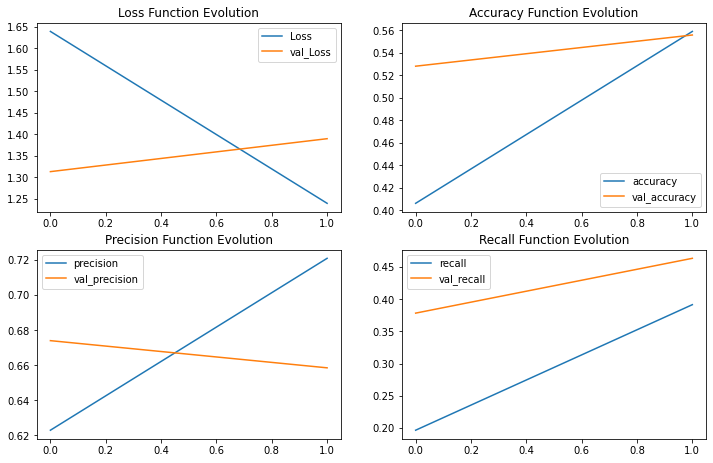

In [17]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [18]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

313/313 [==============================] - 16s 51ms/step - loss: 1.3899 - accuracy: 0.5558 - precision: 0.6585 - recall: 0.4636
Test Accuracy : 55.58%


# Confusion matrix

In [19]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

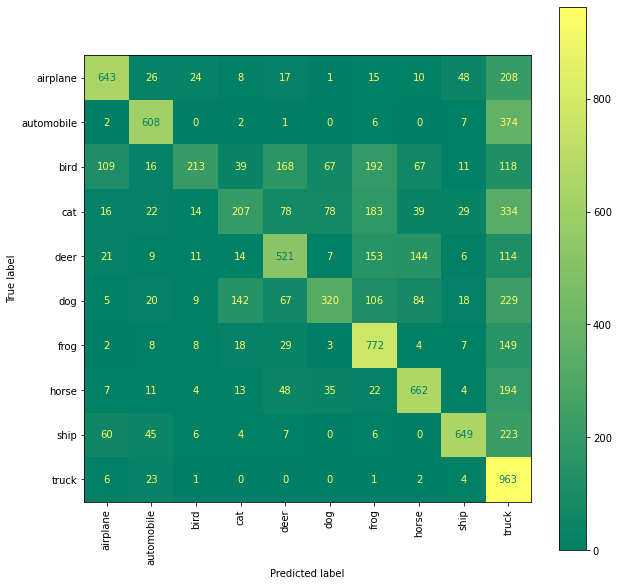

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69      1000
           1       0.77      0.61      0.68      1000
           2       0.73      0.21      0.33      1000
           3       0.46      0.21      0.29      1000
           4       0.56      0.52      0.54      1000
           5       0.63      0.32      0.42      1000
           6       0.53      0.77      0.63      1000
           7       0.65      0.66      0.66      1000
           8       0.83      0.65      0.73      1000
           9       0.33      0.96      0.49      1000

    accuracy                           0.56     10000
   macro avg       0.62      0.56      0.55     10000
weighted avg       0.62      0.56      0.55     10000



# Testing the image

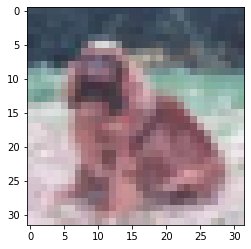

In [22]:
my_image = X_test[101]
plt.imshow(my_image)

In [23]:
# that's a Dog
y_test[101]

array([5], dtype=uint8)

In [25]:

# error predicted as a Dog
np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))

9

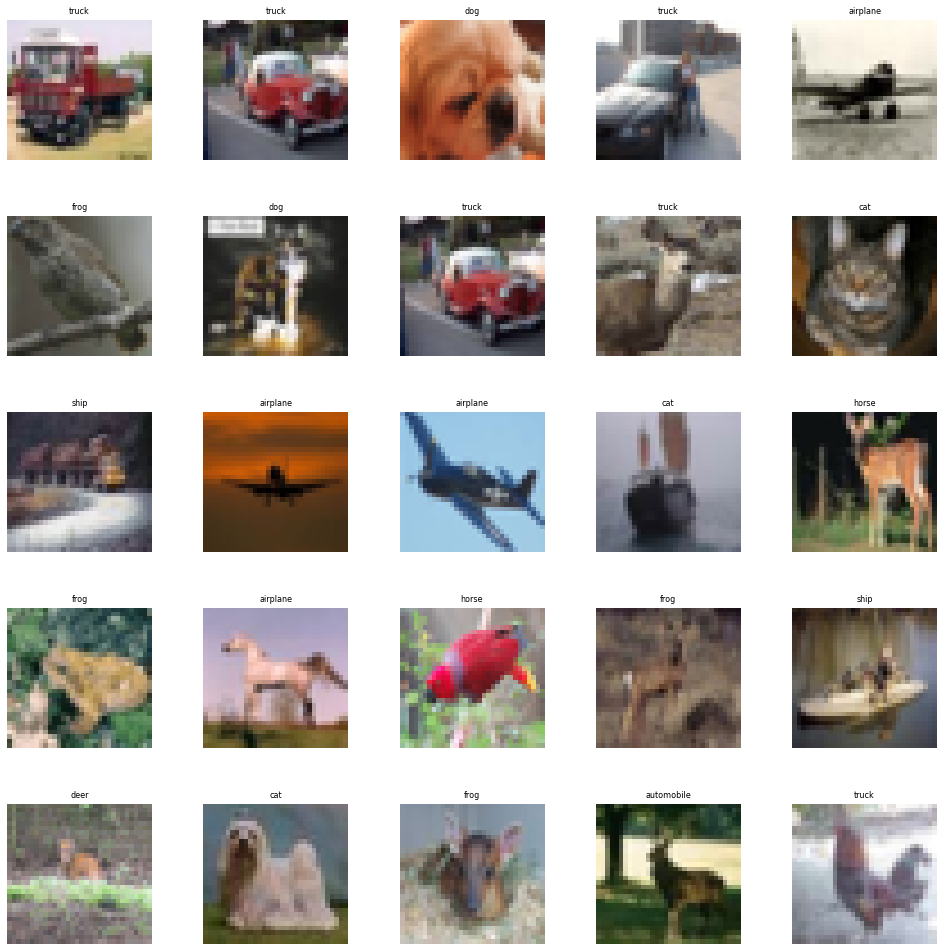

In [26]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 
    
    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
pred